In [1]:
import jax.numpy as jnp
from jax import random
from jax.scipy.special import logit
import jax
import numpy as np

from Simulations.simulation_aux import one_simulation_iter
import Simulations.data_gen as dg

import os


from numpyro.infer import MCMC, NUTS, Predictive


from numpyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, TraceGraph_ELBO
from numpyro.optim import ClippedAdam, Adam
from numpyro.infer.autoguide import AutoDelta, AutoLowRankMultivariateNormal, AutoNormal, AutoDAIS


import src.Models as models
import src.utils as utils

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.funsor import config_enumerate


# --- Set cores and seed ---
N_CORES = 4
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={N_CORES}"


In [2]:

N = 500
# N = 1000
TRIU_DIM = N * (N - 1) // 2

THETA = jnp.array([-2, 1])
# GAMMA_FIX = jnp.array([logit(0.9), logit(0.1), 1])
# GAMMA_FIX = jnp.array([logit(0.85), logit(0.15)])
# GAMMA_X_NOISES = jnp.arange(0.2, 2.2, 0.2)
# GAMMA_X_NOISES = jnp.arange(0, 1.1, 0.1)
GAMMA_F = jnp.array([logit(0.8), logit(0.05)])
GAMMA_REP = jnp.array([logit(0.8), 1, logit(0.15), 1])
GAMMA_NOISE = jnp.arange(0.5, 2.75, 0.25)
GAMMA_NOISE = jnp.arange(0.25, 2.75 + 1e-6, 0.5)


ETA = jnp.array([-1, 3, -0.25, 2])
SIG_INV = 2 / 3
RHO = 0.5
PZ = 0.5

PARAM = {
    "theta": THETA,
    "eta": ETA,
    "rho": RHO,
    "sig_inv": SIG_INV,
}



In [3]:
def combine_single(noise_value):
    # Concatenate: [GAMMA_F, noise_value, GAMMA_REP]
    return jnp.concatenate([GAMMA_F, jnp.array([noise_value]), GAMMA_REP])

GAMMA_arrays = jax.vmap(combine_single)(GAMMA_NOISE)

cur_gamma = GAMMA_arrays[3,:]
cur_gamma

Array([ 1.3862945, -2.944439 ,  1.75     ,  1.3862945,  1.       ,
       -1.734601 ,  1.       ], dtype=float32)

In [4]:
gam = jnp.concatenate([GAMMA_F, jnp.array([GAMMA_NOISE[0]]), GAMMA_REP])

print(f"gam shape: {gam.shape}", "\n", f"gam: {gam}")

gam shape: (7,) 
 gam: [ 1.3862945 -2.944439   0.25       1.3862945  1.        -1.734601
  1.       ]


In [5]:
rng_key = random.PRNGKey(11)
rng = np.random.default_rng(12)

fixed_data = dg.generate_fixed_data(rng, N, PARAM, PZ)

new_interventions = dg.new_interventions_estimands(
        rng, N, fixed_data["x"], fixed_data["triu_star"], ETA
    )

proxy_nets = dg.generate_proxy_networks(
        rng,
        TRIU_DIM,
        fixed_data["triu_star"],
        cur_gamma,
        fixed_data["x_diff"],
        fixed_data["Z"],
    )

data_sim = dg.data_for_sim(fixed_data, proxy_nets)


In [6]:
# get 2x2 table of data_sim.triu_star and data_sim.triu_obs

def binary_contingency_table(A1, A2):
    # Table structure:
    #     A2=0  A2=1
    # A1=0  n00   n01
    # A1=1  n10   n11
    
    n00 = jnp.sum((A1 == 0) & (A2 == 0))
    n01 = jnp.sum((A1 == 0) & (A2 == 1))
    n10 = jnp.sum((A1 == 1) & (A2 == 0))
    n11 = jnp.sum((A1 == 1) & (A2 == 1))
    
    print("A1 \ A2 |  0  |  1  |")
    print("---------|-----|-----|")
    print(f"   0    | {n00:3d} | {n01:3d} |")
    print(f"   1    | {n10:3d} | {n11:3d} |")
    
    # return jnp.array([[n00, n01], [n10, n11]])

binary_contingency_table(data_sim.triu_star, data_sim.triu_obs)

binary_contingency_table(data_sim.triu_star, data_sim.triu_obs_rep)

binary_contingency_table(data_sim.triu_obs, data_sim.triu_obs_rep)

A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 73486 | 33087 |
   1    | 3549 | 14628 |
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 84888 | 21685 |
   1    | 1922 | 16255 |
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 63265 | 13770 |
   1    | 23545 | 24170 |


In [7]:
import jax.numpy as jnp
import jax
import numpyro
import numpyro.distributions as dist

def network_only_models_marginalized(data):
    """
    Bayesian network model with marginalized latent network A*.

    Args:
      data: an object with attributes:
         - x_diff: difference in covariate values per edge (e.g., shape [num_edges])
         - x2_or: indicator if x2_i + x2_j = 1 (shape [num_edges])
         - triu_obs: observed upper-triangular adjacency matrix values (binary, shape [num_edges])
    """
    # --- Priors on continuous parameters ---
    # Using vectorized sample statements for theta (2 parameters) and gamma (3 parameters)
    theta = numpyro.sample("theta", dist.Normal(0, 5).expand([2]))
    gamma = numpyro.sample("gamma", dist.Normal(0, 5).expand([3]))

    # --- Latent network (A*) prior ---
    # Logits for edge probability of A* = 1 (for each edge)
    star_logits = theta[0] + theta[1] * data.x2_or
    star_logits = jnp.clip(star_logits, -20, 20)  # for numerical stability

    # Instead of using x - log1p(exp(x)), we use the stable softplus:
    # log(sigmoid(x)) = -log(1 + exp(-x)) = x - softplus(x)
    # log(1-sigmoid(x)) = -softplus(x)
    log_nu_1 = star_logits - jax.nn.softplus(star_logits)  # log probability for A* = 1
    log_nu_0 = - jax.nn.softplus(star_logits)              # log probability for A* = 0

    # --- Likelihood for the observed network A given A* ---
    # For edges with A* = 1 we use parameter gamma[0], and for A* = 0 we use a logistic regression
    # with linear predictor obs_logits_k0.
    obs_logits_k0 = gamma[1] + gamma[2] * data.x_diff
    obs_logits_k0 = jnp.clip(obs_logits_k0, -20, 20)  # for numerical stability

    # The typical Bernoulli log-likelihood for an observation y given logit ℓ is:
    #   y * ℓ - softplus(ℓ)
    log_xi_1 = data.triu_obs * gamma[0] - jax.nn.softplus(gamma[0])
    log_xi_0 = data.triu_obs * obs_logits_k0 - jax.nn.softplus(obs_logits_k0)

    # --- Marginalizing over A* ---
    # For each edge we have two terms (A* = 1 and A* = 0). Write the joint log-probability
    # for each possibility:
    log_joint_1 = log_nu_1 + log_xi_1
    log_joint_0 = log_nu_0 + log_xi_0

    # Now marginalize: for each edge compute
    # log( xi * nu ) = logaddexp( log_joint_1, log_joint_0 )
    log_marginal = jnp.logaddexp(log_joint_1, log_joint_0)

    # It is often a good idea to use plates over independent observations.
    # Assuming each edge is independent, we can write:
    with numpyro.plate("edges", data.triu_obs.shape[0]):
        # Here we add the contribution for each edge; if you prefer, you can use a dummy observation:
        numpyro.factor("marginalized_likelihood", log_marginal)

    # --- Optional: Compute posterior probabilities for A* (for post-processing) ---
    # p(A* = 1 | data, theta, gamma) = exp( log_joint_1 - log_marginal )
    astar_probs = jnp.exp(log_joint_1 - log_marginal)
    numpyro.deterministic("astar_probs", astar_probs)


In [6]:

logits = 1.2

print("sigmoid", jax.nn.sigmoid(logits), 1-jax.nn.sigmoid(logits))

print("log sigmoid", jax.nn.log_sigmoid(logits), "log 1-sigmoid (jax)", jax.nn.log_sigmoid(-logits), "\n",
      "log 1-sigmoid (manual)", jnp.log(1-jax.nn.sigmoid(logits)))

sigmoid 0.7685248 0.23147517
log sigmoid -0.26328245 log 1-sigmoid (jax) -1.4632825 
 log 1-sigmoid (manual) -1.4632827


In [8]:




# def marginalized_model(data):
#     # priors
#     theta = numpyro.sample("theta", dist.Normal(0, 5).expand([2]))
#     gamma = numpyro.sample("gamma", dist.Normal(0, 5).expand([3]))

#     star_logits = theta[0] + theta[1] * data.x2_or
#     star_logits = jnp.clip(star_logits, -10, 10)  # for numerical stability
#     # P(A*_ij=1)
#     star_logprob = jax.nn.log_sigmoid(star_logits)
#     # P(A*_ij=0)
#     star_logprob_1m = jax.nn.log_sigmoid(-star_logits)

#     obs_logits_k0 = gamma[1] + gamma[2] * data.x_diff
#     obs_logits_k0 = jnp.clip(obs_logits_k0, -10, 10)  # for numerical stability
#     # P(A_ij = 1 | A*_ij = 0)
#     obs_logprobs_k0 = jax.nn.log_sigmoid(obs_logits_k0)
#     # P(A_ij = 0 | A*_ij = 0)
#     obs_logprobs_k0_1m = jax.nn.log_sigmoid(-obs_logits_k0)


#     # P(A_ij = 1 | A*_ij = 1)
#     obs_logprobs_k1 = jax.nn.log_sigmoid(gamma[0])
#     # P(A_ij = 0 | A*_ij = 1)
#     obs_logprobs_k1_1m = jax.nn.log_sigmoid(-gamma[0])

#     # marginalized log-probs P(A_ij=1) 
#     mixed_logprob_a1 = jnp.logaddexp(star_logprob + obs_logprobs_k1, 
#                                    star_logprob_1m + obs_logprobs_k0)
#     mixed_prob_a1 = jnp.exp(mixed_logprob_a1)
    
#     # marginalized log-probs P(A_ij=0)
#     mixed_logprob_a0 = jnp.log1p(-mixed_prob_a1)

#     # log likelihood of A
#     log_lik = jnp.where(data.triu_obs == 1.0,
#                         mixed_logprob_a1,
#                         mixed_logprob_a0)

#     with numpyro.plate("edges", data.triu_obs.shape[0]):
        
#         # numpyro.sample("obs", dist.BernoulliProbs(mixed_probs), obs=data.triu_obs)
#         numpyro.factor("marginalized_likelihood", log_lik)

#     # save posterior A_star probs
#     # let  p_1 = P(A*_ij=1)*P(A_ij| A*_ij=1)
#     #      p_0 = P(A*_ij=0 )*P(A_ij| A*_ij=0)
#     # then posterior probs P(A*_ij | A, \theta,\ gamma) = p_1 / (p_1 + p_0)
#     # log p_1
#     log_branch1 = jnp.where(data.triu_obs == 1.0,
#                             star_logprob + obs_logprobs_k1,
#                             star_logprob + obs_logprobs_k1_1m)
#     # log p_0
#     log_branch0 = jnp.where(data.triu_obs == 1.0,
#                             star_logprob_1m + obs_logprobs_k0,
#                             star_logprob_1m + obs_logprobs_k0_1m)
#     # log (p_0 + p_1)
#     log_norm = jnp.logaddexp(log_branch1, log_branch0)
    
#     numpyro.deterministic("triu_star_probs", jnp.exp(log_branch1 - log_norm))
    


def marginalized_model(data):
    # priors
    theta = numpyro.sample("theta", dist.Normal(0, 5).expand([2]))
    # gamma = numpyro.sample("gamma", dist.Normal(0, 5).expand([3]))
    gamma = numpyro.sample("gamma", dist.Normal(0, 5).expand([3]))

    # P(A*_ij=1)
    # star_logits = theta[0] + theta[1] * data.x2_or
    star_probs = jax.nn.sigmoid(theta[0] + theta[1] * data.x2_or)
    star_probs = jnp.clip(star_probs, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 0)
    # obs_logits_k0 = gamma[1] + gamma[2] * data.x_diff
    obs_probs_k0 = jax.nn.sigmoid(gamma[1] + gamma[2] * data.x_diff)
    obs_probs_k0 = jnp.clip(obs_probs_k0, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 1)
    obs_probs_k1 = jax.nn.sigmoid(gamma[0])
    obs_probs_k1 = jnp.clip(obs_probs_k1, 1e-6, 1 - 1e-6)

    # marginalized probs P(A_ij=1) 
    mixed_probs = star_probs * obs_probs_k1 + (1 - star_probs) * obs_probs_k0

   
    with numpyro.plate("edges", data.triu_obs.shape[0]):
        
        numpyro.sample("obs", dist.BernoulliProbs(mixed_probs), obs=data.triu_obs)

    # save posterior A_star probs
    # let  p_1 = P(A*_ij=1)*P(A_ij| A*_ij=1)
    #      p_0 = P(A*_ij=0 )*P(A_ij| A*_ij=0)
    # then posterior probs P(A*_ij | A, \theta,\ gamma) = p_1 / (p_1 + p_0)
    # numerator aka p_1
    numerator = jnp.where(data.triu_obs == 1.0,
                            star_probs*obs_probs_k1,
                            star_probs*(1-obs_probs_k1))
    # denominator aka p_1 + p_0
    denominator = numerator + jnp.where(data.triu_obs == 1.0,
                                        (1-star_probs)*obs_probs_k0,
                                        (1-star_probs)*(1-obs_probs_k0))

    numpyro.deterministic("triu_star_probs", numerator / denominator)
    

In [8]:
# jax.nn.sigmoid(1.2), 1-jax.nn.sigmoid(1.2), jax.nn.sigmoid(-1.2)

- jnp.log1p(jnp.exp(1.2)), jax.nn.log_sigmoid(-1.2)

(Array(-1.4632825, dtype=float32, weak_type=True),
 Array(-1.4632825, dtype=float32, weak_type=True))

In [9]:


def marginalized_model_rep(data):
    # priors
    theta = numpyro.sample("theta", dist.Normal(0, 5).expand([2]))
    gamma = numpyro.sample("gamma", dist.Normal(0, 5).expand([7]))

    
    # P(A*_ij=1)
    star_probs = jax.nn.sigmoid(theta[0] + theta[1] * data.x2_or)
    star_probs = jnp.clip(star_probs, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 1)
    obs_probs_k1 = jax.nn.sigmoid(gamma[0])
    obs_probs_k1 = jnp.clip(obs_probs_k1, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 0)
    obs_probs_k0 = jax.nn.sigmoid(gamma[1] + gamma[2] * data.x_diff)
    obs_probs_k0 = jnp.clip(obs_probs_k0, 1e-6, 1 - 1e-6)

    # P(A^r_ij=1 | A*_ij=1, A_ij)
    obs_rep_probs_k1 = jax.nn.sigmoid(gamma[3] + gamma[4] * data.triu_obs)
    obs_rep_probs_k1 = jnp.clip(obs_rep_probs_k1, 1e-6, 1 - 1e-6)

    # P(A^r_ij=1 | A*_ij=0, A_ij)
    obs_rep_probs_k0 = jax.nn.sigmoid(gamma[5] + gamma[6] * data.triu_obs)
    obs_rep_probs_k0 = jnp.clip(obs_rep_probs_k0, 1e-6, 1 - 1e-6)

    # compute marginalize probs of (A^_ij=r, A_ij=a), a,r \in {0,1}
    # represent as categorical $C_ij = 2 A_ij + A^r_ij \in {0,1,2,3}
    # Given A*_ij=1
    # p(A_ij=r, A^r_ij=a | A*_ij=1)*P(A*_ij=1)
    pj_star1_cat0 = star_probs * (1 - obs_probs_k1) * (1 - obs_rep_probs_k1)
    pj_star1_cat1 = star_probs * (1 - obs_probs_k1) * obs_rep_probs_k1
    pj_star1_cat2 = star_probs * obs_probs_k1 * (1 - obs_rep_probs_k1)
    pj_star1_cat3 = star_probs * obs_probs_k1 * obs_rep_probs_k1

    # Given A*_ij=0
    # p(A_ij=r, A^r_ij=a | A*_ij=0)*P(A*_ij=0)
    pj_star0_cat0 = (1 - star_probs) * (1 - obs_probs_k0) * (1 - obs_rep_probs_k0)
    pj_star0_cat1 = (1 - star_probs) * (1 - obs_probs_k0) * obs_rep_probs_k0
    pj_star0_cat2 = (1 - star_probs) * obs_probs_k0 * (1 - obs_rep_probs_k0)
    pj_star0_cat3 = (1 - star_probs) * obs_probs_k0 * obs_rep_probs_k0

    # marginalized probs P(C_ij=c) = \sum_{0,1} p(A_ij=r, A^r_ij=a | A*_ij=k)*P(A*_ij=k)
    p_cat0 = pj_star1_cat0 + pj_star0_cat0
    p_cat1 = pj_star1_cat1 + pj_star0_cat1
    p_cat2 = pj_star1_cat2 + pj_star0_cat2
    p_cat3 = pj_star1_cat3 + pj_star0_cat3

    probs = jnp.stack([p_cat0, p_cat1, p_cat2, p_cat3], axis=-1)
    probs = probs / jnp.sum(probs, axis=-1, keepdims=True)

    # observed categorical data
    obs_cat = jnp.astype(2 * data.triu_obs + data.triu_obs_rep, jnp.int32)

    with numpyro.plate("edges", data.triu_obs.shape[0]):
        
        numpyro.sample("obs_joint", dist.Categorical(probs=probs), obs=obs_cat)

    # --- Compute the posterior probability of A*_ij=1 given the joint observation ---
    # Select the appropriate terms based on the observed category
    # p_1 = p(C_ij = c | A*_ij = 1)p(A*_ij = 1)
    numerator = jnp.where(obs_cat == 0, pj_star1_cat0,
                    jnp.where(obs_cat == 1, pj_star1_cat1,
                    jnp.where(obs_cat == 2, pj_star1_cat2,
                               pj_star1_cat3)))
    
    # p_0 = p(C_ij = c | A*_ij = 0)p(A*_ij = 0)
    # denom is p_0 + p_1
    denominator = numerator + jnp.where(obs_cat == 0, pj_star0_cat0,
                              jnp.where(obs_cat == 1, pj_star0_cat1,
                              jnp.where(obs_cat == 2, pj_star0_cat2, 
                                        pj_star0_cat3)))
    # p_1 / (p_0 + p_1)
    posterior_star = numerator / denominator

    # Save the posterior probabilities for A* (for example, on the upper triangle of the network)
    numpyro.deterministic("triu_star_probs", posterior_star)

    

In [19]:
# try with SVI

init_vals = {
    "theta": jnp.array([0.0, 0.0]),
    "gamma": jnp.array([0.0, 0.0, 0.0]),
}

# guide = AutoLowRankMultivariateNormal(marginalized_model)
# guide = AutoDelta(model=marginalized_model,)
                #   init_loc_fn=numpyro.infer.init_to_value(values=init_vals))
# guide = AutoNormal(marginalized_model)
# guide = AutoDelta(marginalized_model)
                                                    #    init_loc_fn=numpyro.infer.init_to_value(values=init_vals))
guide = numpyro.infer.autoguide.AutoMultivariateNormal(marginalized_model)
#                                                        init_loc_fn=numpyro.infer.init_to_value(values=init_vals))
# guide = AutoNormal(network_only_models_marginalized,
                #    init_loc_fn=numpyro.infer.init_to_median)

svi_ = SVI(
    # model=network_only_models_marginalized,
    model=marginalized_model,
    guide=guide,
    # optim=ClippedAdam(0.01),
    # optim=ClippedAdam(0.001),
    optim=Adam(0.001),
    loss=Trace_ELBO(),
    # loss=TraceGraph_ELBO(),
)

# svi_results = svi_.run(random.split(rng_key)[0], 10000, data_sim)
svi_results = svi_.run(random.split(rng_key)[1], 10000, data_sim)

map_params = guide.median(svi_results.params)

print("True theta:", THETA, "\n",
      "Estimated theta:", map_params["theta"], "\n",
      "True gamma:", cur_gamma, "\n",
      "Estimated gamma:", map_params["gamma"], "\n",)

100%|██████████| 10000/10000 [00:35<00:00, 282.14it/s, init loss: 125995.3906, avg. loss [9501-10000]: 75801.5780]


True theta: [-2  1] 
 Estimated theta: [1.6500595 4.393765 ] 
 True gamma: [ 1.3862945 -2.944439   1.25       1.3862945  1.        -1.734601
  1.       ] 
 Estimated gamma: [-0.6534075 -2.1632097 -5.168464 ] 



In [11]:
# with hmc

nuts_kernel = NUTS(marginalized_model)

mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=2)
mcmc.run(random.split(rng_key)[1], data_sim)

mcmc.print_summary()

print("true theta", THETA, "\n",
      "true gamma", cur_gamma)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      0.81      0.17      0.80      0.53      1.07    593.71      1.01
  gamma[1]     -2.95      0.08     -2.95     -3.09     -2.83    463.77      1.01
  gamma[2]      1.28      0.04      1.28      1.22      1.34    451.88      1.01
  theta[0]     -1.82      0.10     -1.81     -1.99     -1.65    431.03      1.01
  theta[1]      1.09      0.05      1.09      1.02      1.18    804.55      1.00

Number of divergences: 0
true theta [-2  1] 
 true gamma [ 1.3862945 -2.944439   1.25       1.3862945  1.        -1.734601
  1.       ]


In [16]:
post_samples = mcmc.get_samples()
post_theta, post_gamma = post_samples["theta"].mean(axis=0), post_samples["gamma"].mean(axis=0)
post_means = {
    "theta": post_theta[None,:],
    "gamma": post_gamma[None,:],
}

print(post_means)

pred = Predictive(model=marginalized_model,
                  posterior_samples=post_means,
                    num_samples=1,
                    return_sites=["triu_star_probs"])(
                        random.PRNGKey(0), data_sim)["triu_star_probs"][0]
post_probs = pred
print(pred.shape)

# post_probs = pred["triu_star_probs"][0]

# print(post_probs.mean(), post_probs.shape)

{'theta': Array([[-1.8216484,  1.0910296]], dtype=float32), 'gamma': Array([[ 0.81281996, -2.9549124 ,  1.2764446 ]], dtype=float32)}
(124750,)


rmse expos: 2.4968088


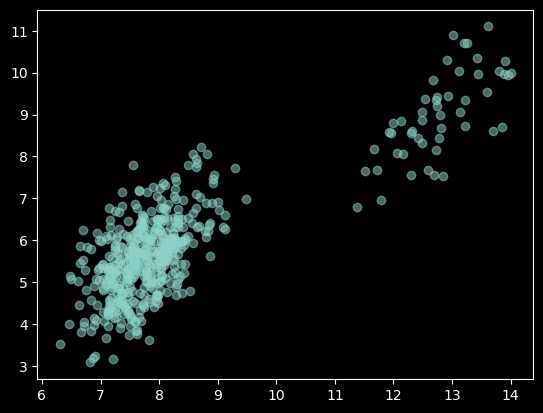

In [17]:
import src.MWG_sampler as mwg
import matplotlib.pyplot as plt

post_triu_star = mwg.sample_posterior_triu_star(rng_key, post_probs)

post_expos = utils.vmap_compute_exposures(post_triu_star, data_sim.Z)

post_expos_mean = post_expos.mean(axis=0)

plt.scatter(post_expos_mean, data_sim.true_exposures, alpha=0.5)

print("rmse expos:", jnp.sqrt(jnp.mean((post_expos_mean - data_sim.true_exposures)**2)))

In [18]:
# SVI to repeated measures


guide_rep = numpyro.infer.autoguide.AutoMultivariateNormal(marginalized_model_rep)

svi_rep = SVI(
    model=marginalized_model_rep,
    guide=guide_rep,
    optim=Adam(0.001),
    loss=Trace_ELBO(),
)

svi_results_rep = svi_rep.run(random.split(rng_key)[1], 10000, data_sim)

map_params_rep = guide_rep.median(svi_results_rep.params)

print("True theta:", THETA, "\n",
        "Estimated theta:", map_params_rep["theta"], "\n",
        "True gamma:", cur_gamma, "\n",
        "Estimated gamma:", map_params_rep["gamma"], "\n",)

100%|██████████| 10000/10000 [01:55<00:00, 86.86it/s, init loss: 249499.2344, avg. loss [9501-10000]: 134275.4487]


True theta: [-2  1] 
 Estimated theta: [-1.9792367  1.0970781] 
 True gamma: [ 1.3862945 -2.944439   1.25       1.3862945  1.        -1.734601
  1.       ] 
 Estimated gamma: [ 0.9461373  -2.830943    1.2136182   0.20015866  2.5888247  -1.7226061
  1.0226827 ] 



In [20]:
# with hmc

nuts_kernel_rep = NUTS(marginalized_model_rep)

mcmc_rep = MCMC(nuts_kernel_rep, num_warmup=1000, num_samples=1000, num_chains=2)
mcmc_rep.run(random.split(rng_key)[0], data_sim)

mcmc_rep.print_summary()

print("true theta", THETA, "\n",
      "true gamma", cur_gamma)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      1.04      0.23      1.00      0.67      1.42    355.86      1.00
  gamma[1]     -2.90      0.05     -2.90     -2.98     -2.82    581.87      1.01
  gamma[2]      1.24      0.03      1.24      1.20      1.28    485.36      1.01
  gamma[3]      0.68      1.08      0.39     -0.30      1.51    209.35      1.00
  gamma[4]      1.75      0.99      1.99      1.10      2.70    214.25      1.01
  gamma[5]     -1.74      0.02     -1.74     -1.78     -1.71   1061.57      1.00
  gamma[6]      1.04      0.04      1.04      0.98      1.09    955.52      1.00
  theta[0]     -1.94      0.09     -1.94     -2.10     -1.79    374.10      1.00
  theta[1]      1.08      0.03      1.08      1.02      1.14    693.51      1.00

Number of divergences: 0
true theta [-2  1] 
 true gamma [ 1.3862945 -2.944439   1.25       1.3862945  1.        -1.734601
  1.       ]


In [21]:
post_samples = mcmc_rep.get_samples()
post_theta, post_gamma = post_samples["theta"].mean(axis=0), post_samples["gamma"].mean(axis=0)
post_means = {
    "theta": post_theta[None,:],
    "gamma": post_gamma[None,:],
}

print(post_means)

pred = Predictive(model=marginalized_model_rep,
                  posterior_samples=post_means,
                    num_samples=1,
                    return_sites=["triu_star_probs"])(
                        random.PRNGKey(0), data_sim)["triu_star_probs"][0]
post_probs = pred
print(pred.shape)

{'theta': Array([[-1.9429432,  1.0814283]], dtype=float32), 'gamma': Array([[ 1.0389366 , -2.8958557 ,  1.2404262 ,  0.67951983,  1.7450302 ,
        -1.7401551 ,  1.036875  ]], dtype=float32)}
(124750,)


rmse expos: 1.0735581


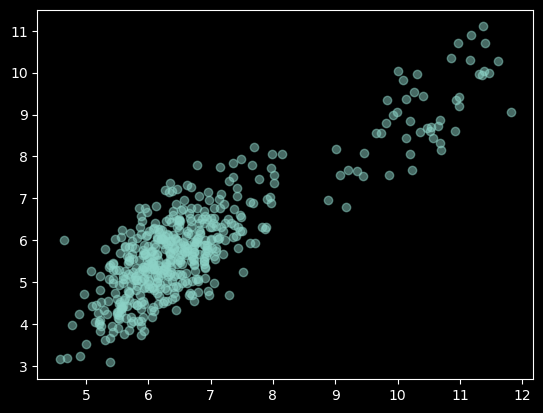

In [22]:
post_triu_star = mwg.sample_posterior_triu_star(rng_key, post_probs)

post_expos = utils.vmap_compute_exposures(post_triu_star, data_sim.Z)

post_expos_mean = post_expos.mean(axis=0)

plt.scatter(post_expos_mean, data_sim.true_exposures, alpha=0.5)

print("rmse expos:", jnp.sqrt(jnp.mean((post_expos_mean - data_sim.true_exposures)**2)))

In [19]:

def network_mixture_model(data):
    """
    Model that embeds the likelihood in a mixture distribution.

    Args:
      data: an object with attributes:
           - x_diff: a 1D array (one per edge) of differences in covariates,
           - x2_or: a 1D array of indicators (one per edge) for whether x2_i + x2_j = 1,
           - triu_obs: a 1D array of observed edge indicators (binary; one per edge).
    """
    # --- Priors ---
    # theta: parameters for the latent network A*
    theta = numpyro.sample("theta", dist.Normal(0, 3).expand([2]))
    # gamma: parameters for the edge likelihood given A*
    gamma = numpyro.sample("gamma", dist.Normal(0, 3).expand([3]))

    # --- Latent network A* prior embedded in the mixture weights ---
    # Compute the logits for the latent A* for each edge.
    star_logits = theta[0] + theta[1] * data.x2_or
    star_logits = jnp.clip(star_logits, -20, 20)  # avoid overflow
    # Prior probability for A* = 1:
    prior_Astar_1 = jax.nn.sigmoid(star_logits)
    # Mixture probabilities: first component corresponds to A* = 0, second to A* = 1.
    mix_probs = jnp.stack([1 - prior_Astar_1, prior_Astar_1], axis=-1)

    # # The probability that A* = 1 is sigmoid(star_logits)
    # # Create a 2-element vector of mixture weights for each edge:
    # # component 0 (A* = 0) gets weight 1 - sigmoid(star_logits)
    # # component 1 (A* = 1) gets weight sigmoid(star_logits)
    # mix_probs = jnp.stack([1 - jax.nn.sigmoid(star_logits),
    #                        jax.nn.sigmoid(star_logits)], axis=-1)

    # --- Likelihood for A given A* ---
    # When A* = 0, we use a logistic regression with linear predictor:
    obs_logits_k0 = gamma[1] + gamma[2] * data.x_diff
    obs_logits_k0 = jnp.clip(obs_logits_k0, -20, 20)  # avoid overflow

    # When A* = 1, the likelihood is given by a fixed Bernoulli with logit gamma[0].
    comp_logits = jnp.stack([obs_logits_k0,
                             gamma[0] * jnp.ones_like(obs_logits_k0)], axis=-1)

    # --- Define the mixture distribution ---
    # The mixture is over two Bernoulli components.
    mixture_dist = dist.MixtureSameFamily(
        # The categorical mixing distribution with probabilities given per edge.
        mixing_distribution=dist.Categorical(probs=mix_probs),
        # The two components: Bernoulli with logits defined in comp_logits.
        component_distribution=dist.Bernoulli(logits=comp_logits)
    )

    # --- Observation ---
    # Each edge is conditionally independent.
    with numpyro.plate("edges", data.triu_obs.shape[0]):
        numpyro.sample("obs", mixture_dist, obs=data.triu_obs)

    # --- Compute the posterior probabilities for A* ---
    # Compute the log-likelihoods for each component for each edge.
    # For component 0 (A* = 0):
    log_lik_0 = data.triu_obs * obs_logits_k0 - jax.nn.softplus(obs_logits_k0)
    # For component 1 (A* = 1):
    log_lik_1 = data.triu_obs * gamma[0] - jax.nn.softplus(gamma[0])
    
    # Incorporate the log prior probabilities:
    log_prior_0 = jnp.log(1 - prior_Astar_1)
    log_prior_1 = jnp.log(prior_Astar_1)
    
    log_joint_0 = log_prior_0 + log_lik_0
    log_joint_1 = log_prior_1 + log_lik_1
    
    # Normalizing constant per edge:
    log_norm = jnp.logaddexp(log_joint_0, log_joint_1)
    # Posterior probability for A* = 1:
    astar_probs = jnp.exp(log_joint_1 - log_norm)
    
    # Return as a deterministic output (for each edge)
    numpyro.deterministic("triu_star_probs", astar_probs)


In [20]:

# --- Compile the model ---

# guide = AutoDelta(network_only_models_marginalized)
# guide = AutoDAIS(network_mixture_model)
guide = AutoDelta(network_mixture_model)
# guide = AutoNormal(network_mixture_model)
# guide = AutoNormal(network_only_models_marginalized,
                #    init_loc_fn=numpyro.infer.init_to_median)

svi_ = SVI(
    # model=network_only_models_marginalized,
    model=network_mixture_model,
    guide=guide,
    # optim=ClippedAdam(0.01),
    optim=ClippedAdam(0.001),
    loss=Trace_ELBO(),
    # loss=TraceGraph_ELBO(),
)

svi_results = svi_.run(random.split(rng_key)[0], 10000, data_sim)

map_params = guide.median(svi_results.params)

print("True theta:", THETA, "\n",
      "Estimated theta:", map_params["theta"], "\n",
      "True gamma:", GAMMA, "\n",
      "Estimated gamma:", map_params["gamma"], "\n",)

100%|██████████| 10000/10000 [01:51<00:00, 89.74it/s, init loss: 99731.1875, avg. loss [9501-10000]: 76585.8731]


True theta: [-2  1] 
 Estimated theta: [-2.216671  1.095719] 
 True gamma: [ 1.7346013 -1.734601   0.4      ] 
 Estimated gamma: [ 1.6451411  -1.5856683   0.36345416] 



In [27]:
TRIU_DIM = N * (N - 1) // 2

@config_enumerate  # This enables automatic enumeration of discrete latent variables.
def model_enumerated(data):
    """
    Model with explicit enumeration of discrete latent variable A*.
    
    Args:
        data: An object with attributes:
              - x_diff: (num_edges,) covariate differences per edge.
              - x2_or: (num_edges,) indicator for x2_i + x2_j == 1.
              - triu_obs: (num_edges,) observed binary outcomes.
              - num_edges: integer number of edges.
    """
    # Priors for continuous parameters.
    with numpyro.plate("theta_plate", 2):
        theta = numpyro.sample("theta", dist.Normal(0, 3))

    with numpyro.plate("gamma_plate", 3):
        gamma = numpyro.sample("gamma", dist.Normal(0, 3))
    # theta = numpyro.sample("theta", dist.Normal(0, 3).expand([2]))
    # gamma = numpyro.sample("gamma", dist.Normal(0, 3).expand([3]))


    # Compute logits for the latent variable A*
    star_logits = theta[0] + theta[1] * data.x2_or

    # Use a plate to vectorize over edges.
    with numpyro.plate("triu_vals", size=TRIU_DIM):
        # Sample A_star (latent binary variable) and enumerate it.
        A_star = numpyro.sample(
            "A_star",
            dist.Bernoulli(logits=star_logits),
            infer={'enumerate': 'parallel'}  # Enables automatic marginalization.
        )

        # Define the observation likelihood:
        # If A_star == 1: use gamma[0] (true positives)
        # If A_star == 0: use gamma[1] + gamma[2] * x_diff (false positives)
        obs_logits = jnp.where(A_star, gamma[0], gamma[1] + gamma[2] * data.x_diff)

        # Observations
        numpyro.sample("obs", dist.Bernoulli(logits=obs_logits), obs=data.triu_obs)


In [39]:
from numpyro.infer import SVI, TraceEnum_ELBO
from numpyro.optim import ClippedAdam
from numpyro.infer.autoguide import AutoDelta, AutoLowRankMultivariateNormal
# from numpyro.infer.initialization import init_to_value
import numpyro.handlers as handlers

import jax

# def guide_map(data):
#     # with handlers.block(model_enumerated, hide=["A_star"]):  # Ignore discrete latent variable
#         # return AutoDelta(model_enumerated)(data)
#     block_model = handlers.block(model_enumerated, hide=["A_star"])
#     return AutoDelta(block_model)(data)

blocked_model = handlers.block(model_enumerated, hide=["A_star"])
guide_map = AutoLowRankMultivariateNormal(blocked_model)
# guide_map = AutoDelta(blocked_model)

# guide_map = AutoLowRankMultivariateNormal(model_enumerated,)

# Define the AutoDelta guide

# init_strategy = init_to_value(values={"theta": jnp.zeros(2), "gamma": jnp.zeros(3)})
# guide_map = AutoDelta(model_enumerated, init_loc_fn=init_strategy)

optim = ClippedAdam(0.001)

# Initialize the SVI object with TraceEnum_ELBO.
svi = SVI(model_enumerated, guide_map, optim, 
          loss=TraceEnum_ELBO(max_plate_nesting=1))

# Assume data_sim is your data object with the required attributes.
rng_key = jax.random.PRNGKey(0)
svi_result = svi.run(rng_key, num_steps=10000, data=data_sim)

# You can extract the learned parameters and monitor the ELBO:
params = svi_result.params

AssertionError: 

In [27]:
print("true gamma: ", GAMMA, "\n",
      "loc_gamma: ", params["gamma_loc"], "\n",
      "true theta", THETA, "\n",
      "loc_theta: ", params["theta_loc"])


true gamma:  [ 2.1972244 -2.1972246  0.5      ] 
 loc_gamma:  [ 1.2437049  -2.1805823   0.48870432] 
 true theta [-2.5  1. ] 
 loc_theta:  [-2.3604188  1.016937 ]


In [ ]:

# net_mod_kernel = NUTS(models.network_only_models_marginalized)
# net_mod_kernel = NUTS(model_enumerated)

# mcmc_net = MCMC(
#     net_mod_kernel,
#     num_warmup=2000,
#     num_samples=2500,
#     num_chains=1,
#     # chain_method="parallel",
#     progress_bar=True,
# )   

# mcmc_net.run(rng_key, data_sim)

# mcmc_net.print_summary()

# mcmc_samps = mcmc_net.get_samples()

warmup:   1%|▏         | 66/4500 [01:15<2:16:07,  1.84s/it, 319 steps of size 4.09e-03. acc. prob=0.74] 

In [32]:
import torch
import numpy as np

data_torch = {
    "x_diff": torch.tensor(np.array(data_sim.x_diff)),
    "x2_or": torch.tensor(np.array(data_sim.x2_or)),
    "triu_obs": torch.tensor(np.array(data_sim.triu_obs))
}


In [38]:
import pyro
from tqdm import tqdm

@pyro.infer.config_enumerate
def pyro_noisy_networks_model(data):
    """
    Network model for one noisy observed network. True network is geenrated from LSM.
    :param x: pairwise x-differences
    :param x2: pariwise x2-equality
    :param triu_v: observed triu values (upper triangular)
    :param N: number of units
    :param K: latent variables dimension
    """

    with pyro.plate("theta_dim", 2):
        theta = pyro.sample("theta", pyro.distributions.Normal(0, 5))
        # theta = pyro.sample("theta", pyro.distributions.StudentT(df=5, loc=0, scale=2))

    mu_net = theta[0] + theta[1]*data["x2_or"]
    mu_net = torch.clamp(mu_net, min=-30, max=30)

    with pyro.plate("gamma_i", 3):
        gamma = pyro.sample("gamma", pyro.distributions.Normal(0, 5))
        # gamma = pyro.sample("gamma", pyro.distributions.StudentT(df=5, loc=0, scale=2))

    with pyro.plate("A* and A", data["triu_obs"].shape[0]):
        triu_star = pyro.sample(
            "triu_star",
            pyro.distributions.Bernoulli(logits=mu_net),
            infer={"enumerate": "parallel"},
        )

        logit_misspec = torch.where(
            triu_star == 1.0, gamma[0], gamma[1] + gamma[2] * data["x_diff"]
        )

        pyro.sample(
            "obs_triu", pyro.distributions.Bernoulli(logits=logit_misspec), obs=data["triu_obs"]
        )

def get_guide():
        return pyro.infer.autoguide.AutoLowRankMultivariateNormal(
            pyro.poutine.block(pyro_noisy_networks_model, hide=["triu_star"]),
            init_loc_fn=pyro.infer.autoguide.init_to_median(),
        )

pyro.clear_param_store()

py_guide = get_guide()
loss_fn = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)
optimizer = pyro.optim.ClippedAdam({"lr": 0.001})
svi = pyro.infer.SVI(pyro_noisy_networks_model, py_guide, optimizer, loss=loss_fn)

num_steps = 10000
losses_full = []
for step in tqdm(range(num_steps)):
    # svi.step(data_torch)
    loss = svi.step(data_torch)
    losses_full.append(loss)
    if step % 100 == 0:
        print(f"Step {step} - Loss: {loss}")




  0%|          | 4/10000 [00:00<10:01, 16.60it/s]

Step 0 - Loss: 69965.71875


  1%|          | 105/10000 [00:03<05:17, 31.21it/s]

Step 100 - Loss: 69948.84375


  2%|▏         | 205/10000 [00:06<04:32, 35.93it/s]

Step 200 - Loss: 67969.46875


  3%|▎         | 305/10000 [00:09<04:27, 36.30it/s]

Step 300 - Loss: 67478.7734375


  4%|▍         | 405/10000 [00:12<04:22, 36.60it/s]

Step 400 - Loss: 67736.3125


  5%|▌         | 505/10000 [00:15<04:48, 32.86it/s]

Step 500 - Loss: 67390.9140625


  6%|▌         | 606/10000 [00:18<05:11, 30.12it/s]

Step 600 - Loss: 67246.765625


  7%|▋         | 706/10000 [00:22<04:42, 32.92it/s]

Step 700 - Loss: 67075.6796875


  8%|▊         | 803/10000 [00:25<04:38, 33.07it/s]

Step 800 - Loss: 67086.96875


  9%|▉         | 905/10000 [00:28<04:11, 36.15it/s]

Step 900 - Loss: 67046.6640625


 10%|█         | 1007/10000 [00:32<05:09, 29.10it/s]

Step 1000 - Loss: 67020.984375


 11%|█         | 1104/10000 [00:35<05:13, 28.34it/s]

Step 1100 - Loss: 66963.109375


 12%|█▏        | 1204/10000 [00:39<05:30, 26.65it/s]

Step 1200 - Loss: 66987.796875


 13%|█▎        | 1307/10000 [00:42<04:10, 34.72it/s]

Step 1300 - Loss: 66988.4609375


 14%|█▍        | 1405/10000 [00:46<04:35, 31.16it/s]

Step 1400 - Loss: 67166.9453125


 15%|█▌        | 1506/10000 [00:49<05:19, 26.58it/s]

Step 1500 - Loss: 66937.3359375


 16%|█▌        | 1606/10000 [00:53<04:32, 30.76it/s]

Step 1600 - Loss: 66907.65625


 17%|█▋        | 1704/10000 [00:56<05:00, 27.59it/s]

Step 1700 - Loss: 66967.96875


 18%|█▊        | 1806/10000 [01:01<05:10, 26.43it/s]

Step 1800 - Loss: 66888.3671875


 19%|█▉        | 1908/10000 [01:04<03:44, 35.99it/s]

Step 1900 - Loss: 66965.7421875


 20%|██        | 2004/10000 [01:07<04:04, 32.65it/s]

Step 2000 - Loss: 66858.6640625


 21%|██        | 2104/10000 [01:10<03:50, 34.30it/s]

Step 2100 - Loss: 66854.1484375


 22%|██▏       | 2206/10000 [01:14<04:49, 26.91it/s]

Step 2200 - Loss: 66886.1640625


 23%|██▎       | 2307/10000 [01:18<03:54, 32.87it/s]

Step 2300 - Loss: 66849.84375


 24%|██▍       | 2403/10000 [01:21<05:07, 24.74it/s]

Step 2400 - Loss: 66833.25


 25%|██▌       | 2507/10000 [01:25<03:34, 34.88it/s]

Step 2500 - Loss: 66830.890625


 26%|██▌       | 2605/10000 [01:28<03:54, 31.50it/s]

Step 2600 - Loss: 66866.640625


 27%|██▋       | 2707/10000 [01:32<03:51, 31.49it/s]

Step 2700 - Loss: 66826.3359375


 28%|██▊       | 2807/10000 [01:35<03:43, 32.25it/s]

Step 2800 - Loss: 66830.7578125


 29%|██▉       | 2907/10000 [01:38<03:24, 34.60it/s]

Step 2900 - Loss: 66826.8203125


 30%|███       | 3007/10000 [01:41<03:17, 35.34it/s]

Step 3000 - Loss: 66824.3203125


 31%|███       | 3103/10000 [01:45<05:52, 19.54it/s]

Step 3100 - Loss: 66820.5234375


 32%|███▏      | 3205/10000 [01:50<04:21, 26.01it/s]

Step 3200 - Loss: 66830.3359375


 33%|███▎      | 3307/10000 [01:54<04:11, 26.66it/s]

Step 3300 - Loss: 66831.3359375


 34%|███▍      | 3403/10000 [01:59<04:27, 24.67it/s]

Step 3400 - Loss: 66815.59375


 35%|███▌      | 3503/10000 [02:04<03:51, 28.11it/s]

Step 3500 - Loss: 66818.96875


 36%|███▌      | 3605/10000 [02:08<03:34, 29.78it/s]

Step 3600 - Loss: 66822.9453125


 37%|███▋      | 3703/10000 [02:11<03:23, 30.88it/s]

Step 3700 - Loss: 66814.890625


 38%|███▊      | 3804/10000 [02:15<03:23, 30.51it/s]

Step 3800 - Loss: 66821.5


 39%|███▉      | 3906/10000 [02:18<03:19, 30.55it/s]

Step 3900 - Loss: 66824.46875


 40%|████      | 4005/10000 [02:22<03:26, 28.98it/s]

Step 4000 - Loss: 66822.6484375


 41%|████      | 4105/10000 [02:25<03:14, 30.32it/s]

Step 4100 - Loss: 66813.5546875


 42%|████▏     | 4203/10000 [02:29<03:10, 30.38it/s]

Step 4200 - Loss: 66818.421875


 43%|████▎     | 4306/10000 [02:34<03:15, 29.12it/s]

Step 4300 - Loss: 66808.7890625


 44%|████▍     | 4404/10000 [02:37<03:37, 25.74it/s]

Step 4400 - Loss: 66807.9453125


 45%|████▌     | 4505/10000 [02:41<03:00, 30.50it/s]

Step 4500 - Loss: 66814.6640625


 46%|████▌     | 4605/10000 [02:45<04:01, 22.37it/s]

Step 4600 - Loss: 66808.0625


 47%|████▋     | 4703/10000 [02:49<03:09, 27.88it/s]

Step 4700 - Loss: 66808.921875


 48%|████▊     | 4807/10000 [02:54<02:59, 28.97it/s]

Step 4800 - Loss: 66808.46875


 49%|████▉     | 4906/10000 [02:58<03:15, 26.05it/s]

Step 4900 - Loss: 66806.6796875


 50%|█████     | 5007/10000 [03:01<02:57, 28.15it/s]

Step 5000 - Loss: 66809.34375


 51%|█████     | 5104/10000 [03:05<02:58, 27.50it/s]

Step 5100 - Loss: 66804.2890625


 52%|█████▏    | 5207/10000 [03:10<02:44, 29.22it/s]

Step 5200 - Loss: 66809.4609375


 53%|█████▎    | 5306/10000 [03:13<02:42, 28.88it/s]

Step 5300 - Loss: 66812.9921875


 54%|█████▍    | 5405/10000 [03:17<02:44, 27.99it/s]

Step 5400 - Loss: 66805.78125


 55%|█████▌    | 5503/10000 [03:21<04:09, 18.04it/s]

Step 5500 - Loss: 66805.2890625


 56%|█████▌    | 5604/10000 [03:29<06:27, 11.35it/s]

Step 5600 - Loss: 66804.9453125


 57%|█████▋    | 5705/10000 [03:33<03:04, 23.32it/s]

Step 5700 - Loss: 66803.6796875


 58%|█████▊    | 5806/10000 [03:36<02:13, 31.44it/s]

Step 5800 - Loss: 66803.3515625


 59%|█████▉    | 5906/10000 [03:40<02:05, 32.54it/s]

Step 5900 - Loss: 66805.0546875


 60%|██████    | 6005/10000 [03:43<02:20, 28.41it/s]

Step 6000 - Loss: 66805.6875


 61%|██████    | 6107/10000 [03:46<01:59, 32.50it/s]

Step 6100 - Loss: 66804.0


 62%|██████▏   | 6207/10000 [03:49<01:53, 33.31it/s]

Step 6200 - Loss: 66800.6953125


 63%|██████▎   | 6307/10000 [03:52<01:42, 36.05it/s]

Step 6300 - Loss: 66808.2109375


 64%|██████▍   | 6407/10000 [03:55<01:41, 35.33it/s]

Step 6400 - Loss: 66803.9375


 65%|██████▌   | 6505/10000 [03:59<02:05, 27.74it/s]

Step 6500 - Loss: 66803.96875


 66%|██████▌   | 6603/10000 [04:02<01:43, 32.82it/s]

Step 6600 - Loss: 66802.3515625


 67%|██████▋   | 6706/10000 [04:05<01:37, 33.94it/s]

Step 6700 - Loss: 66802.1171875


 68%|██████▊   | 6806/10000 [04:08<01:33, 34.21it/s]

Step 6800 - Loss: 66803.78125


 69%|██████▉   | 6905/10000 [04:11<01:47, 28.76it/s]

Step 6900 - Loss: 66800.953125


 70%|███████   | 7006/10000 [04:15<01:23, 35.65it/s]

Step 7000 - Loss: 66801.1953125


 71%|███████   | 7106/10000 [04:17<01:18, 37.07it/s]

Step 7100 - Loss: 66798.8203125


 72%|███████▏  | 7206/10000 [04:20<01:19, 35.26it/s]

Step 7200 - Loss: 66800.125


 73%|███████▎  | 7302/10000 [04:23<01:20, 33.70it/s]

Step 7300 - Loss: 66800.8125


 74%|███████▍  | 7406/10000 [04:26<01:12, 35.88it/s]

Step 7400 - Loss: 66800.6015625


 75%|███████▌  | 7506/10000 [04:29<01:10, 35.63it/s]

Step 7500 - Loss: 66801.3515625


 76%|███████▌  | 7606/10000 [04:32<01:03, 37.51it/s]

Step 7600 - Loss: 66800.765625


 77%|███████▋  | 7706/10000 [04:35<01:13, 31.21it/s]

Step 7700 - Loss: 66805.21875


 78%|███████▊  | 7806/10000 [04:38<01:07, 32.47it/s]

Step 7800 - Loss: 66801.34375


 79%|███████▉  | 7906/10000 [04:41<00:56, 37.38it/s]

Step 7900 - Loss: 66800.828125


 80%|████████  | 8006/10000 [04:44<00:59, 33.37it/s]

Step 8000 - Loss: 66805.2265625


 81%|████████  | 8106/10000 [04:47<00:53, 35.20it/s]

Step 8100 - Loss: 66802.171875


 82%|████████▏ | 8206/10000 [04:50<00:59, 30.06it/s]

Step 8200 - Loss: 66799.8125


 83%|████████▎ | 8306/10000 [04:53<00:58, 28.99it/s]

Step 8300 - Loss: 66800.3046875


 84%|████████▍ | 8408/10000 [04:56<00:44, 35.71it/s]

Step 8400 - Loss: 66796.09375


 85%|████████▌ | 8504/10000 [04:59<00:43, 34.30it/s]

Step 8500 - Loss: 66804.4296875


 86%|████████▌ | 8608/10000 [05:02<00:38, 36.24it/s]

Step 8600 - Loss: 66796.7421875


 87%|████████▋ | 8708/10000 [05:05<00:36, 35.57it/s]

Step 8700 - Loss: 66802.3046875


 88%|████████▊ | 8804/10000 [05:08<00:34, 34.79it/s]

Step 8800 - Loss: 66796.6484375


 89%|████████▉ | 8907/10000 [05:11<00:31, 35.15it/s]

Step 8900 - Loss: 66798.3984375


 90%|█████████ | 9007/10000 [05:14<00:29, 33.16it/s]

Step 9000 - Loss: 66797.0


 91%|█████████ | 9107/10000 [05:17<00:25, 34.38it/s]

Step 9100 - Loss: 66795.859375


 92%|█████████▏| 9207/10000 [05:20<00:26, 30.26it/s]

Step 9200 - Loss: 66799.4140625


 93%|█████████▎| 9307/10000 [05:23<00:21, 31.96it/s]

Step 9300 - Loss: 66796.796875


 94%|█████████▍| 9404/10000 [05:26<00:17, 34.11it/s]

Step 9400 - Loss: 66797.03125


 95%|█████████▌| 9507/10000 [05:29<00:15, 32.86it/s]

Step 9500 - Loss: 66796.453125


 96%|█████████▌| 9604/10000 [05:32<00:12, 32.93it/s]

Step 9600 - Loss: 66800.2890625


 97%|█████████▋| 9706/10000 [05:35<00:08, 34.68it/s]

Step 9700 - Loss: 66800.7578125


 98%|█████████▊| 9805/10000 [05:39<00:06, 30.11it/s]

Step 9800 - Loss: 66796.421875


 99%|█████████▉| 9907/10000 [05:42<00:02, 32.37it/s]

Step 9900 - Loss: 66795.7734375


100%|██████████| 10000/10000 [05:45<00:00, 28.94it/s]


In [39]:

params = py_guide.median()

print("true gamma: ", GAMMA, "\n",
        "map gamma: ", params["gamma"], "\n",
        "true theta", THETA, "\n",
        "map theta: ", params["theta"])

true gamma:  [ 2.1972244 -2.1972246  0.5      ] 
 map gamma:  tensor([-0.0290, -2.4265,  0.5974]) 
 true theta [-2.5  1. ] 
 map theta:  tensor([-1.3854,  1.0348])
